<a href="https://colab.research.google.com/github/sarathsreedharan/CSU_CS_445/blob/main/Spring25/Notebooks/module08-03-transformers-contd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformers: Revenge of the Networks

In [ ]:
import numpy as np

## Properties of Attention

Multi-headed self-attention is the core modeling component of Transformers.

Recall that attention can be viewed as an operation on a query $q\in\mathbb{R}^d$, a set of value vectors $\{v_1,\ldots,v_n\}$, $v_i\in\mathbb{R}^d$, and a set of key vectors $\{k_1,\ldots,k_n\}$, $k_i\in\mathbb{R}^d$, specified as follows:
\begin{equation}
c=\sum_{i=1}^n v_i\alpha_i
\end{equation}
\begin{equation}
\alpha_i=\dfrac{\exp(k_i^\top q)}{\sum_{j=1}^n\exp(k_j^\top q)},
\end{equation}
where $\alpha_i$ are frequently called the "attention weights", and the output $c\in\mathbb{R}^d$ is a correspondingly weighted average over the value vectors.

It's particularly simple for attention to "copy" a value vector to the output $c$.

For $c$ to be approximately equal to $v_j$, $k_j^\top q$ should be relatively large, which can happen when $k_j$ and/or $q$ are relatively large and point in roughly the same direction, while the other $k_i$ are roughly orthogonal to $q$. (Trivially, if all of the $v_i$ are approximately equal to each other, then so will $c$ be.)

In [ ]:
# toy example with orthogonal K vectors and equal-length query
V = np.random.uniform(-1,1,size=(3,3))
K = np.array([[1,0,0],
              [0,1,0],
              [0,0,1]])
q = np.array([0,1,0]) + np.random.uniform(-.01,.01,size=(3,))

alpha = np.exp(K.T @ q)/np.sum(np.exp(K.T @ q))
print(alpha,V,V.T @ alpha,np.allclose(V.T @ alpha,V[1]))

[0.21163017 0.57640222 0.21196761] [[ 0.00226544 -0.03356713  0.21980202]
 [-0.07147272 -0.31360029 -0.92967035]
 [ 0.22847857  0.6739347  -0.83983578]] [ 0.00771246 -0.04501139 -0.6673653 ] False


In [ ]:
# make one key large
V = np.random.uniform(-1,1,size=(3,3))
K = np.array([[1,0,0],
              [0,20,0],
              [0,0,1]])
q = np.array([0,1,0]) + np.random.uniform(-.01,.01,size=(3,))

alpha = np.exp(K.T @ q)/np.sum(np.exp(K.T @ q))
print(alpha,V,V.T @ alpha,np.allclose(V.T @ alpha,V[1]))

[2.23430114e-09 9.99999996e-01 2.23784453e-09] [[ 0.08852328 -0.2962662  -0.87455059]
 [-0.27916976 -0.82515604 -0.68182753]
 [ 0.73153863 -0.89563775 -0.74404042]] [-0.27916975 -0.82515604 -0.68182753] True


In [ ]:
# different key
V = np.random.uniform(-1,1,size=(3,3))
K = np.array([[20,0,0],
              [0,1,0],
              [0,0,1]])
q = np.array([1,0,0]) + np.random.uniform(-.01,.01,size=(3,))

alpha = np.exp(K.T @ q)/np.sum(np.exp(K.T @ q))
print(alpha,V,V.T @ alpha,np.allclose(V.T @ alpha,V[0]))

[9.99999996e-01 1.86938365e-09 1.86341842e-09] [[ 0.35185978 -0.71377887  0.90807102]
 [ 0.73349967  0.63372146 -0.05139053]
 [ 0.8285758  -0.74065813  0.9394479 ]] [ 0.35185978 -0.71377887  0.90807102] True


What would this mean (choose all that apply)?
1. The query vector is ignoring certain elements of the input.
2. The attention weights are evenly distributed across the input.
3. One particular element of the input carries almost all the relevant information (as judged by the network).

Consider a set of key vectors $\{k_1,\ldots,k_n\}$ where all key vectors are perpendicular, that is, $k_i\perp k_j$ for all $i\neq j$. Let $||k_i||=1$ for all $i$. Let $\{v_1,\ldots,v_n\}$ be a set of arbitrary value vectors.

Let $v_a,v_b\in\{v_1,\ldots,v_n\}$ be two of the value vectors, and let the corresponding key vectors of $v_a$ and $v_b$ be $k_a$ and $k_b$.

Give an expression for a query vector $q$ such that the output $c$ is approximately equal to the average of $v_a$ and $v_b$, that is, $\frac{1}{2}(v_a+v_b)$.

In [ ]:
V = np.random.uniform(-1,1,size=(3,3))
K = np.array([[1,0,0],
              [0,1,0],
              [0,0,1]])

for beta in range(1,21):
    q = beta * (K[0]+K[1])
    alpha = np.exp(K.T @ q)/np.sum(np.exp(K.T @ q))
    print(beta, V.T @ alpha, .5 * (V[0]+V[1]), np.allclose(V.T @ alpha, .5 * (V[0]+V[1])))

1 [0.3174877  0.44397629 0.21328666] [0.19246124 0.61697466 0.18604583] False
2 [0.24346485 0.54640126 0.19715853] [0.19246124 0.61697466 0.18604583] False
3 [0.2120075  0.5899286  0.19030458] [0.19246124 0.61697466 0.18604583] False
4 [0.19976403 0.60686983 0.18763697] [0.19246124 0.61697466 0.18604583] False
5 [0.19516329 0.61323585 0.18663456] [0.19246124 0.61697466 0.18604583] False
6 [0.19345738 0.6155963  0.18626287] [0.19246124 0.61697466 0.18604583] False
7 [0.19282798 0.61646719 0.18612574] [0.19246124 0.61697466 0.18604583] False
8 [0.1925962  0.61678792 0.18607524] [0.19246124 0.61697466 0.18604583] False
9 [0.19251089 0.61690595 0.18605665] [0.19246124 0.61697466 0.18604583] False
10 [0.1924795  0.61694938 0.18604981] [0.19246124 0.61697466 0.18604583] False
11 [0.19246796 0.61696536 0.1860473 ] [0.19246124 0.61697466 0.18604583] False
12 [0.19246371 0.61697124 0.18604637] [0.19246124 0.61697466 0.18604583] False
13 [0.19246215 0.6169734  0.18604603] [0.19246124 0.61697466 

* Any expression $q=\beta(k_a+k_b)$, for large $\beta$, will work here.
* While the softmax function will never *exactly* average the two vectors, you can get close by using a large scalar multiple in the expression.

It is *possible* for a single-headed attention mechanism to focus equally on two values. The same concept could easily be extended to any subset of values.

Consider a set of key vectors $\{k_1,\ldots,k_n\}$ that are now randomly sampled, $k_i\sim\mathcal{N}(\mu_i,\Sigma_i)$, where the means $\mu_i$ are known to you, but the covariances $\Sigma_i$ are unknown. Further, assume that the means $\mu_i$ are all perpendicular; $\mu_i^\top\mu_j=0$ if $i\neq j$, and unit norm, $||\mu_i||=1$.

Assume that the covariance matrices are $\Sigma_i=\alpha I$, for vanishingly small $\alpha$. ($I$ is the identity matrix.) Let us design a query $q$ in terms of the $\mu_i$ such that as before, $c\approx\frac{1}{2}(v_a+v_b)$.

In [ ]:
V = np.random.uniform(-1,1,size=(3,3))
mean = (1,1,1)
#sigma = np.eye(3,3)*np.random.uniform(.00001,.0001,size=(3,))
K = np.random.multivariate_normal(mean,np.eye(3,3)*np.random.uniform(.000000000001,.00000000001),size=(3,))

mu = np.eye(3,3)*np.mean(K, axis=0)
print(K)
print(mu)

for beta in range(1,201):
    q = beta * (mu[0]+mu[1])
    alpha = np.exp(mu.T @ q)/np.sum(np.exp(mu.T @ q))
    print(beta, V.T @ alpha, .5 * (V[0]+V[1]), np.allclose(V.T @ alpha, .5 * (V[0]+V[1])))

[[1.00000216 1.00000296 0.99999714]
 [0.99999743 0.99999771 0.99999975]
 [0.99999855 0.99999994 0.99999676]]
[[0.99999938 0.         0.        ]
 [0.         1.00000021 0.        ]
 [0.         0.         0.99999788]]
1 [ 0.32500814  0.20712639 -0.11239126] [ 0.32464904  0.2803116  -0.28705116] False
2 [ 0.32479616  0.25045662 -0.2157991 ] [ 0.32464904  0.2803116  -0.28705116] False
3 [ 0.32470632  0.26887076 -0.25974383] [ 0.32464904  0.2803116  -0.28705116] False
4 [ 0.32467162  0.27603787 -0.27684717] [ 0.32464904  0.2803116  -0.28705116] False
5 [ 0.32465883  0.27873123 -0.28327377] [ 0.32464904  0.2803116  -0.28705116] False
6 [ 0.32465435  0.27973006 -0.28565635] [ 0.32464904  0.2803116  -0.28705116] False
7 [ 0.32465295  0.28009874 -0.28653507] [ 0.32464904  0.2803116  -0.28705116] False
8 [ 0.3246527   0.28023469 -0.28685833] [ 0.32464904  0.2803116  -0.28705116] False
9 [ 0.32465286  0.28028488 -0.28697696] [ 0.32464904  0.2803116  -0.28705116] False
10 [ 0.32465318  0.2803035

* Any expression $q=\beta(\mu_a+\mu_b)$, for large $\beta$, will work here. If $\alpha$ is vanishingly small, then for all $i$, $k_i\approx\mu_i$.

Though single-headed attention is resistant to small perturbations in the keys, some types of larger perturbations may pose a bigger issue.

Specifically, in some cases, one key vector $k_a$ may have a larger or smaller norm than the others, while still pointing in the same direction as $\mu_a$.

As an example, let us consider a covariance for item $a$ as $\Sigma_a=\alpha I+\frac{1}{2}(\mu_a\mu_a^\top)$ for vanishingly small $\alpha$. Further, let $\Sigma_i=\alpha I$ for all $i\neq a$.

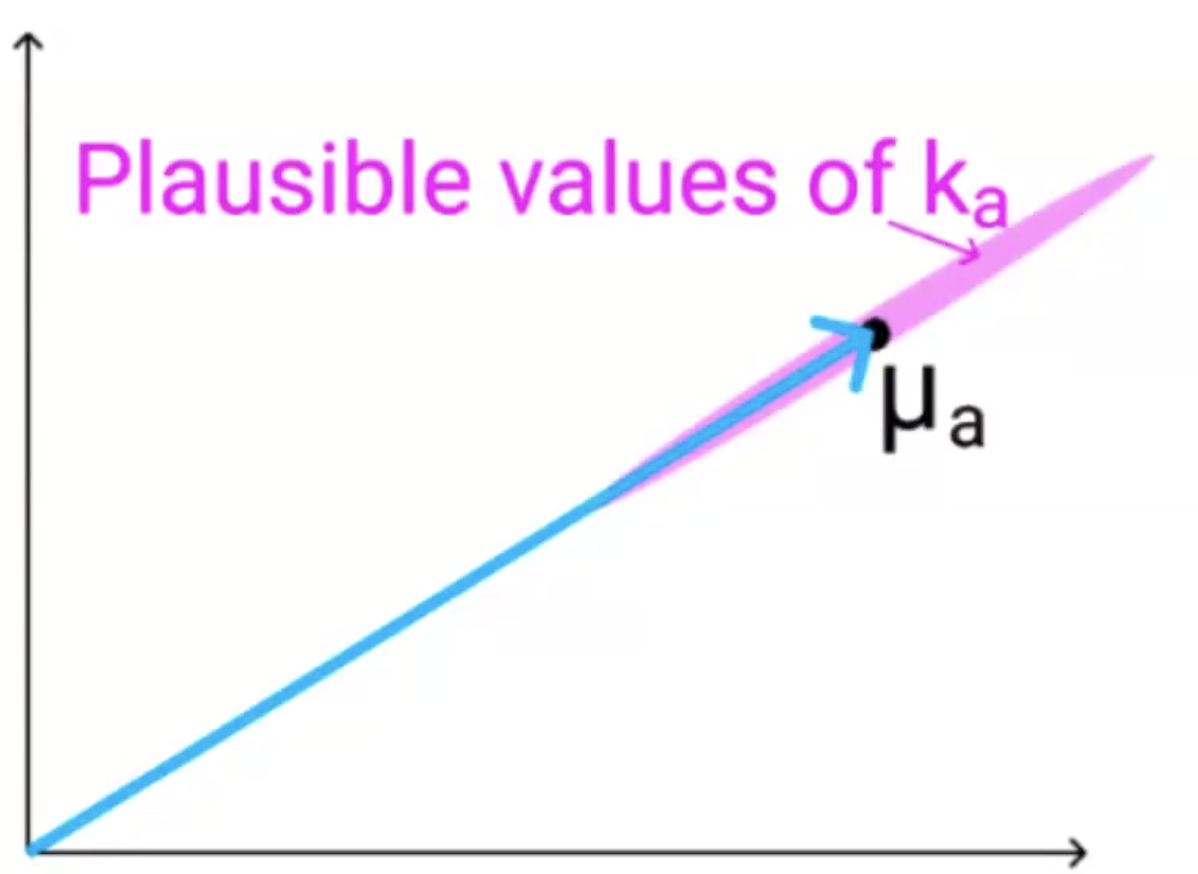

When you sample $\{k_1,\ldots,k_n\}$ multiple times, and use the $q$ vector defined above ($q = \beta(\mu_a + \mu_b)$), what (qualitatively) do you expect the vector $c$ will look like for different samples?

* The greater $||k_a||$ is, the more $c$ will look like $v_a$, while the smaller $||k_a||$ is, the more $c$ will look like $v_b$.

Therefore this is not a *practical* solution.

Now we'll see some of the power of multi-headed attention.

Consider a simple version of multi-headed attention which is identical to single-headed self-attention as we've presented it, except two query vectors ($q_1$ and $q_2$) are defined, which leads to a pair of vectors ($c_1$ and $c_2$), each the output of single-headed attention given its respective query vector.

The final output of the multi-headed attention is their average, $\frac{1}{2}(c_1+c_2)$.

Consider a set of key vectors $\{k_1,\ldots,k_n\}$ that are randomly sampled, $k_i\sim\mathcal{N}(\mu_i,\Sigma_i)$, where the means $\mu_i$ are known to you, but the covariances $\Sigma_i$ are unknown. Also as before, assume that the means $\mu_i$ are mutually orthogonal; $\mu_i^\top\mu_j=0$ if $i\neq j$, and unit norm, $||\mu_i||=1$.

Assume that the covariance matrices are $\Sigma_i=\alpha I$, for vanishingly small $\alpha$. Design $q_1$ and $q_2$ such that $c$ is approximately equal to $\frac{1}{2}(v_a+v_b)$.

* Any expressions $q_1=\beta_1\mu_a$ and $q_2=\beta_2\mu_b$, for large $\beta_1$ and $\beta_2$, will work here.

Assume that the covariance matrices are $\Sigma_a=\alpha I+\frac{1}{2}(\mu_a\mu_a^\top)$ for vanishingly small $\alpha$, and $\Sigma_i=\alpha I$ for all $i\neq a$. Take the query vectors $q_1$ and $q_2$ above.

What, qualitatively, would you expect the output $c$ to look like across different samples of the key vectors?

* We expect $c$ to look like $\frac{1}{2}(v_a+v_b)$, no matter what $||k_a||$ is.
* We expect $c_1$ to look like $v_a$, since $k_a$ points in roughly the same direction as $q_1$, while the other $k_i$ are roughly orthogonal to $q_1$.
* Likewise, we expect $c_2$ to look like $v_b$. So $c=\frac{1}{2}(c_1+c_2)\approx\frac{1}{2}(v_a+v_b)$.

So far, we've discussed attention as a function on a set of key vectors, a set of value vectors, and a query vector. In Transformers, we perform *self-attention*, which roughly means that we draw the keys, values, and queries from the same data.

More precisely, let $\{x_1,\ldots,x_n\}$ be a sequence of vectors in $\mathbb{R}^d$. Think of each $x_i$ as representing word $i$ in a sentence. One form of self-attention defines keys, queries, and values as follows. Let $V,K,Q\in\mathbb{R}^{d\times d}$ be parameter matrices. Then
\begin{equation}
v_i=Vx_i,i\in\{1,\ldots,n\}
\end{equation}
\begin{equation}
k_i=Kx_i,i\in\{1,\ldots,n\}
\end{equation}
\begin{equation}
q_i=Qx_i,i\in\{1,\ldots,n\}.
\end{equation}
Then we get a context vector for each input $i$; we have $c_i=\Sigma_{j=1}^n\alpha_{ij}v_j$, where $\alpha_{ij}$ is defined as $\alpha_{ij}=\frac{\exp(k_j^\top q_i)}{\sum_{\ell=1}^n\exp(k_\ell^\top q_i)}$. Note that this is single-headed self-attention.

We'll show how key-value-query attention like this allows the network to use different aspects of the input vectors $x_i$ in how it defines keys, queries, and values. Intuitively, this allows networks to choose different aspects of $x_i$ to be the "content" (value vector) versus what it uses to determine "where to look" for content (keys and queries).

First, consider if we didn't have key-query-value attention. For keys, queries, and values we'll just use $x_i$; that is, $v_i=q_i=k_i=x_i$. We'll consider a specific set of $x_i$. In particular, let $u_a,u_b,u_c,u_d$ be mutually orthogonal vectors in $\mathbb{R}^d$, each with equal norm $||u_a||=||u_b||=||u_c||=||u_d||=\beta$, where $\beta$ is very large. Now, let our $x_i$ be:
\begin{equation}
x_1=u_d+u_b
\end{equation}
\begin{equation}
x_2=u_a
\end{equation}
\begin{equation}
x_3=u_c+u_b.
\end{equation}
If we perform self-attention with these vectors, what vector does $c_2$ approximate? Would it be possible for $c_2$ to approximate $u_b$ by adding either $u_d$ or $u_c$ to $x_2$?

* We expect $c_2$ to look like $u_a$.
* It is not possible for $c_2$ to approximate $u_b$ by adding either $u_d$ or $u_c$ to $x_2$.
* Since $q_2=k_2$, and they are very large and point in the same direction (because they are the same), while the other $k_i$ point in different directions, $k_2^\top q_2$ will be much larger than the other $k_i^\top q_2$, and so $c_2$ will be approximately equal to $v_2=x_2\neq u_b$.

Now consider using key-query-value attention as we've defined it originally. Using the same definitions of $x_1$, $x_2$, and $x_3$ as above, we want to specify matrices $K,Q,V$ such that $c_2\approx u_b$, and $c_1\approx u_b-u_c$.

Some outer product properties may be helpful:

For orthogonal vectors $u,v,w\in\mathbb{R}^d$, the outer product $uv^\top$ is a matrix in $\mathbb{R}^{d\times d}$, and $(uv^\top)v=u(v^\top v)=u||v||_2^2$, and $(uv^\top)w=u(v^\top w)=u\ast 0$ (The last equality is because $v$ and $w$ are orthogonal).

There are many solutions to this problem.  One such is:

$$V=\frac{1}{\beta^2}(u_b u_b^\top-u_c u_c^\top)$$

$$Q=u_d u_a^\top+u_c u_d^\top$$

$$K=I$$

The idea is that when multiplying a matrix $uv^\top$ and a vector $w$, the result will be either a scalar multiple of $u$ if $v$ and $w$ are not orthogonal, or $\mathbf{0}$ if they are.

In [ ]:
u = np.random.uniform(-1,1,size=(1,3))
v = np.array([[0,0,2]])
w = np.array([[0,0,1]])

print(w @ (v.T @ u))
print(w @ (v.T @ u)/u)

v = np.array([[0,2,0]])
w = np.array([[0,0,1]])

print(w @ (v.T @ u))
print(w @ (v.T @ u)/u)

[[-0.28504581 -1.52601644 -1.47858088]]
[[2. 2. 2.]]
[[0. 0. 0.]]
[[-0. -0. -0.]]


Applying this idea to $V$, we want $u_b$ to appear in both $v_1$ and $v_3$, so we can let $u=u_b$. Then $v$ should be orthogonal to neither $x_1$ nor $x_3$; $v=u_b$ works. Therefore, we know that $u_bu_b^\top$ should appear somewhere in $V$. Then we want $-u_c$ to appear in $v_3$ but not $v_1$, so we let $u=-u_c$, and $v=u_c$ is orthogonal to $x_1$ but not $x_3$, giving us another term $-u_cu_c^\top$ to include in $V$. Finally, we add $u_bu_b^\top$ and $-u_cu_c^\top$ and factor out a scalar multiple of $\beta^2$ to get $V=\frac{1}{\beta^2}(u_b u_b^\top-u_c u_c^\top)$.

Then for $Q$ and $K$, we basically want $q_2$ to match $k_1$ and $q_1$ to match $k_3$. For simplicity, we can let $K=I$. One possible way to do the matching is to let $q_2$ be (a scalar multiple of) $u_d$ and $q_1$ be (a scalar multiple of) $u_c$; one can verify that $k_1^\top q_2$ and $k_3^\top q_1$ will be very large, while the other combinations of $k_j^\top q_i$ will be 0. Then we can apply the same idea as before: $u=u_d$ and $v=u_a$ handle $q_2$, while $u=u_c$ and $v=u_d$ handle $q_1$; add them to get $Q=u_d u_a^\top+u_c u_d^\top$.

We can finally verify that:

$v_1=u_b\hspace{20mm}$
$v_2=\mathbf{0}\hspace{20mm}$
$v_3=u_b-u_c$

$q_1=\beta^2u_cv\hspace{14mm}$
$q_2=\beta^2u_d\hspace{14mm}$
$q_3=\mathbf{0}$

$k_1=u_d+u_b\hspace{11mm}$
$k_2=u_a\hspace{18mm}$
$k_3=u_c+u_b$

$c_1\approx u_b-u_c\hspace{12mm}$
$c_2\approx u_b\hspace{19mm}$
$c_3=\frac{2}{3}u_b-\frac{1}{3}u_c$

## BERT

**BERT**: *B*idirectional *E*ncoder *R*epresentations from *T*ransformers.

The name is a lie.  BERT actually consumes all the input at once, making it *non*directional.  But that would be NERT, which sounds stupid.

Responsible for the profusion of muppet-named models in NLP.

<img src="https://github.com/sarathsreedharan/CSU_CS_445/blob/main/Spring25/Notebooks/images/bert_models_layout.jpeg?raw=1">

You can't go to a \*ACL conference without being assaulted by muppets.  I've got PTSD.

Published in 2018 on arXiv (Devlin et al.).  Published at NAACL 2019 as some kind of goof or weird flex, I guess.  Won best paper.

BERT is trained on 2 tasks: *Masked Language Modeling* (MLM) and *Next Sentence Prediction* (NSP).

<img src="https://github.com/sarathsreedharan/CSU_CS_445/blob/main/Spring25/Notebooks/images/mlm.png?raw=1" width=500>

**In the MLM task** 15% of the words in each sequence are replaced with a [MASK] token. The model then attempts to predict the original value of the masked words, based on the context provided by the other, non-masked, words in the sequence.

Why 15%?

# 🤷‍♂️

It seemed to work best.

Within that 15%:

* 80% of the tokens are actually replaced with the token [MASK].
* 10% of the time tokens are replaced with a random token.
* 10% of the time tokens are left unchanged.

This is because the model needs to be trained to predict a word regardless of whether or not the [MASK] token is there in the input; it should predict all the time.

While training the BERT loss function considers only the prediction of the masked tokens and ignores the prediction of the non-masked ones. This is just one reason why BERT is slow to train.

<img src="https://github.com/sarathsreedharan/CSU_CS_445/blob/main/Spring25/Notebooks/images/nsp.png?raw=1" width=500>

**In the NSP task**, there are two sentences structured like so:

    [CLS] <sentence 1> [SEP] <sentence 2> [SEP]

The [CLS] token is trained to contain an embedding that, when softmaxed, will result in one of two labels: `IsNext` or `NotNext`, depending on if `<sentence 2>` is determined to follow `<sentence 1>` or not.

During training the model is fed with two input sentences at a time such that:

* 50% of the time the second sentence comes after the first one.
* 50% of the time it is a random sentence from the full corpus.

The two sentences also have a token-level mask associated with them, of all 0s for tokens belonging to the first sentence, and all 1s for tokens belonging to the second sentence.

Therefore, when performing BERT tasks with only one sentence (as we will do), you mask all tokens with 1s.

## Attention Mechanism In Practice

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

### Inputs to the scoring function

Let's start by looking at the inputs we'll give to the scoring function. We will assume we're in the first step in the decoding phase. The first input to the scoring function is $s_t$, the hidden state of decoder (assume only three hidden nodes -- not usable in real life, but easier to illustrate):

<AxesSubplot:>

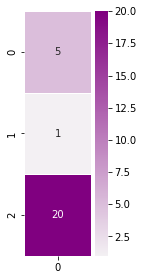

In [ ]:
dec_hidden_state = [5,1,20]
plt.figure(figsize=(1.5, 4.5))
sns.heatmap(np.transpose(np.matrix(dec_hidden_state)), annot=True, \
            cmap=sns.light_palette("purple", as_cmap=True), linewidths=1)

Our first scoring function will score a single encoder hidden state $h_i$, which looks like this:

In [ ]:
enc_hidden_state = [3,12,45]

<AxesSubplot:>

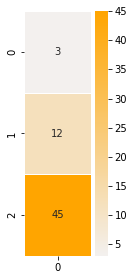

In [ ]:
# Let's visualize our encoder hidden state
plt.figure(figsize=(1.5, 4.5))
sns.heatmap(np.transpose(np.matrix(enc_hidden_state)), annot=True,\
            cmap=sns.light_palette("orange", as_cmap=True), linewidths=1)

In [ ]:
# Score using dot product
np.dot(dec_hidden_state, enc_hidden_state)

927

This is single-head dot-product attention: $s_th_i$

### Scoring multiple inputs at once

In [ ]:
annotations = np.transpose([[3,12,45], [59,2,5], [1,43,5], [4,3,45.3]])

Now every column is a hidden state (i.e., embedding)

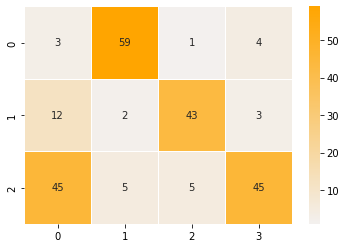

In [ ]:
ax = sns.heatmap(annotations, annot=True, cmap=sns.light_palette("orange", as_cmap=True),\
                 linewidths=1)

### Scoring All Annotations at Once

In [ ]:
attention_weights_raw = np.array(dec_hidden_state).T @ annotations
attention_weights_raw

array([927., 397., 148., 929.])

Which of these inputs will get the most attention from this decoder?

Once more using scaled dot-product attention.

In [ ]:
attention_weights_scaled = (np.array(dec_hidden_state).T @ annotations)/np.sqrt(3)
attention_weights_scaled

array([535.20369954, 229.20805687,  85.44783984, 536.35840008])

The formula for attention is: $$\text{Attention}(s,h) = \text{softmax}(\frac{s_t^Th_i}{\sqrt n})$$

We've done $\frac{s_t^Th_i}{\sqrt n}$, so let's apply softmax.

In [ ]:
def softmax(x):
    x = np.array(x, dtype=float)
    e_x = np.exp(x)
    return e_x / e_x.sum(axis=0)

In [ ]:
attention_weights = softmax(attention_weights_scaled)
attention_weights

array([2.39631558e-001, 3.07131891e-134, 1.12994145e-196, 7.60368442e-001])

In [ ]:
(attention_weights_scaled[0],attention_weights_scaled[3]),\
(attention_weights[0],attention_weights[3])

((535.2036995387831, 536.3584000771624),
 (0.2396315581419701, 0.7603684418580298))

Notice how now, even though the raw and scaled raw attention weights for indices 0 and 3 were really close, after softmax, the difference is stark.

### Apply the attention weights back onto the inputs

In [ ]:
# just a simple elementwise multiplication
applied_attention = attention_weights * annotations
applied_attention

array([[7.18894674e-001, 1.81207816e-132, 1.12994145e-196,
        3.04147377e+000],
       [2.87557870e+000, 6.14263782e-134, 4.85874824e-195,
        2.28110533e+000],
       [1.07834201e+001, 1.53565945e-133, 5.64970726e-196,
        3.44446904e+001]])

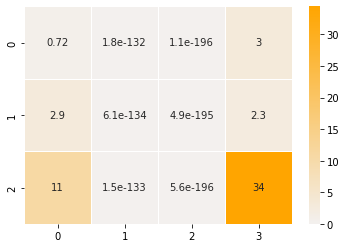

In [ ]:
# Let's visualize our annotations after applying attention to them
ax = sns.heatmap(applied_attention, annot=True,\
                 cmap=sns.light_palette("orange", as_cmap=True), linewidths=1)

Contrast this with the raw inputs visualized earlier in the notebook, and we can see that the second and third inputs (columns) have been nearly wiped out. The first annotation maintains some of its value, and the fourth annotation is the most pronounced.

### Calculating the attention context vector

<AxesSubplot:>

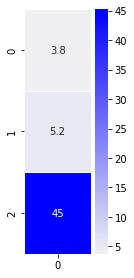

In [ ]:
# sum across the rows of the attention applied to inputs
attention_vector = np.sum(applied_attention, axis=1)
plt.figure(figsize=(1.5, 4.5))
sns.heatmap(np.transpose(np.matrix(attention_vector)), annot=True,\
            cmap=sns.light_palette("Blue", as_cmap=True), linewidths=1)

## Playing with BERT

In this section, we're going to compare the behavior of BERT, the original, and RoBERTa, a **R**obustly **O**ptimized **BERT** Pretraining **A**pproach, on the Masked Language Model task, one of the tasks BERT was originally trained on.

In [ ]:
import numpy as np
import torch
from itertools import product
from transformers import BertTokenizer, BertModel, RobertaTokenizer, RobertaModel

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt

# Load pre-trained model tokenizer (vocabulary)
bert_base_cased_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# Load pre-trained model (weights)
bert_base_cased_model = BertModel.from_pretrained('bert-base-cased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states
                                  )

# Load pre-trained model tokenizer (vocabulary)
roberta_base_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Load pre-trained model (weights)
roberta_base_model = RobertaModel.from_pretrained('roberta-base',
                                  output_hidden_states = True, # Whether the model returns all hidden-states
                                  )

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# define a cosine similarity function
def cos_sim(a,b):
    return np.inner(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

Get sentence and token embeddings (same as Lecture 25).

In [ ]:
'''Get the embedding for a single sentence'''
def get_sentence_embedding(text, tokenizer, model):

    # Add the special tokens
    marked_text = text
    if isinstance(model,BertModel):
        marked_text = "[CLS] " + text + " [SEP]"

    # Split the sentence into tokens
    tokenized_text = tokenizer.tokenize(marked_text)

    # Map the token strings to their vocabulary indices
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

    # Display the words with their indices
    for i, tup in enumerate(zip(tokenized_text, indexed_tokens)):
        print('{:} {:<12} {:>6,}'.format(i, tup[0], tup[1]))

    # Mark each token as belonging to sentence "1"
    segments_ids = [1] * len(tokenized_text)

    # Convert inputs to PyTorch tensors
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])

    model.eval()

    # Run the text through BERT, and collect all of the hidden states produced
    # from all 12 layers.
    with torch.no_grad():

        outputs = model(tokens_tensor, segments_tensors)

        # Evaluating the model will return a different number of objects based on
        # how it's  configured in the `from_pretrained` call earlier. In this case,
        # becase we set `output_hidden_states = True`, the third item will be the
        # hidden states from all layers. See the documentation for more details:
        # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
        hidden_states = outputs[2]

    print("Number of layers:", len(hidden_states), "  (initial embeddings + 12 BERT layers)")
    layer_i = 0

    print("Number of batches:", len(hidden_states[layer_i]))
    batch_i = 0

    print("Number of tokens:", len(hidden_states[layer_i][batch_i]))
    token_i = 0

    print("Number of hidden units:", len(hidden_states[layer_i][batch_i][token_i]))

    return tokenized_text, outputs[0], outputs[1], hidden_states

In [ ]:
'''Returns embeddings for tokens and indices in "indices", concatenated and summed over the last n layers'''
def get_token_embeddings(token_embeddings, last_n_layers, indices):

    # Stores the token vectors
    token_vecs_cat = []

    # `token_embeddings` is a [N x 12 x 768] tensor.

    # For each token in the sentence...
    for token in token_embeddings:

        # `token` is a [12 x 768] tensor

        # Concatenate the vectors (that is, append them together) from the last
        # four layers.
        # Each layer vector is 768 values, so `cat_vec` is length last_n_layers*768
        layer_reps = []
        for n in range(1,last_n_layers+1):
            layer_reps.append(token[-n])
            cat_vec = torch.cat(tuple(layer_reps), dim=0)

        # Use `cat_vec` to represent `token`
        token_vecs_cat.append(cat_vec)

    print ('Concatenated embeddings shape is: %d x %d' % (len(token_vecs_cat), len(token_vecs_cat[0])))

    # Stores the token vectors
    token_vecs_sum = []

    # For each token in the sentence...
    for token in token_embeddings:

        # `token` is a [12 x 768] tensor

        # Sum the vectors from the last four layers.
        sum_vec = torch.sum(token[-n:], dim=0)

        # Use `sum_vec` to represent `token`.
        token_vecs_sum.append(sum_vec)

    print ('Summed embeddings shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))

    return token_vecs_cat, token_vecs_sum

In [ ]:
def calc_similarities(tokenized_text, cat_embeddings, sum_embeddings, indices):
    i2i = dict(zip(indices,[i for i in range(len(indices))]))

    for i1,i2 in list(product(indices, repeat=2)):
        if i1 != i2:
            print("Cosine similarity between %s (%s) and %s (%s) (concatenated embeddings): %.4f" % \
                  (tokenized_text[i1], i1, tokenized_text[i2], i2, \
                   cos_sim(cat_embeddings[i2i[i1]],cat_embeddings[i2i[i2]])))
            print("Cosine similarity between %s (%s) and %s (%s) (summed embeddings): %.4f\n" % \
                  (tokenized_text[i1], i1, tokenized_text[i2], i2, \
                   cos_sim(sum_embeddings[i2i[i1]],sum_embeddings[i2i[i2]])))

This test sentence below serves the same purpose as multiple uses of the word "bank" (from Lecture 25), except here we're looking at "bed", which occurs as a whole word, and also part of the word "embedding."  Because of BERT's fixed vocabulary, "embedded" appears as its own word, and doesn't need the subword, like "embedding(s)" does.

In [ ]:
text = "After calculating some embeddings for an embedded system and turning over the flower beds, the professor went to bed."
tokenized_text, seq_embedding, pooled_embedding, hidden_states = \
    get_sentence_embedding(text, bert_base_cased_tokenizer, bert_base_cased_model)

0 [CLS]           101
1 After         1,258
2 calculating  23,172
3 some          1,199
4 em            9,712
5 ##bed         4,774
6 ##ding        3,408
7 ##s           1,116
8 for           1,111
9 an            1,126
10 embedded     11,783
11 system        1,449
12 and           1,105
13 turning       3,219
14 over          1,166
15 the           1,103
16 flower        7,366
17 beds          9,884
18 ,               117
19 the           1,103
20 professor     3,083
21 went          1,355
22 to            1,106
23 bed           1,908
24 .               119
25 [SEP]           102
Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 26
Number of hidden units: 768


Let's look at the similarities between different occurrences of "bed", as a whole word, and a subword, and associated terms.

In [ ]:
token_embeddings = torch.squeeze(torch.stack(hidden_states, dim=0), dim=1).permute(1,0,2)
indices = [4,5,10,17,23]
cat_embeddings, sum_embeddings = get_token_embeddings(token_embeddings, 4, indices)
calc_similarities(tokenized_text, cat_embeddings, sum_embeddings, indices)

Concatenated embeddings shape is: 26 x 3072
Summed embeddings shape is: 26 x 768
Cosine similarity between em (4) and ##bed (5) (concatenated embeddings): 0.6543
Cosine similarity between em (4) and ##bed (5) (summed embeddings): 0.6699

Cosine similarity between em (4) and embedded (10) (concatenated embeddings): 0.6703
Cosine similarity between em (4) and embedded (10) (summed embeddings): 0.6889

Cosine similarity between em (4) and beds (17) (concatenated embeddings): 0.6401
Cosine similarity between em (4) and beds (17) (summed embeddings): 0.6595

Cosine similarity between em (4) and bed (23) (concatenated embeddings): 0.5851
Cosine similarity between em (4) and bed (23) (summed embeddings): 0.6089

Cosine similarity between ##bed (5) and em (4) (concatenated embeddings): 0.6543
Cosine similarity between ##bed (5) and em (4) (summed embeddings): 0.6699

Cosine similarity between ##bed (5) and embedded (10) (concatenated embeddings): 0.6593
Cosine similarity between ##bed (5) and 

I'm also going to look at the similarities between occurrences of "bed" and the pooled embedding, or the embedding of the [CLS] token.

In [ ]:
for i in range(len(sum_embeddings)):
    print(cos_sim(sum_embeddings[i],pooled_embedding[0]))

0.043538228
0.029575096
0.07148381
0.048761006
0.053450435
0.047518592
0.038523562
0.033171542
0.058744162
0.060452648
0.06925282
0.05077903
0.0812717
0.0075849914
0.043029685
0.031228842
0.01775464
0.008402588
0.017173048
0.028169237
0.039336994
0.016609754
-0.0045498535
0.0037792975
0.03786347
0.019259058


No close similarity between any mention of "bed" and the meaning of the whole sentence.  The pooled embedding would also be different from the average of all the contextualized token embedding.

Now, I want to look at the similarity between things I *know* should be very different: named entities.

In [ ]:
sentence_ids = {}
cat_embeddings = {}
sum_embeddings = {}

In [ ]:
text = "President Joseph R. Biden, Jr. met virtually on November 15 with President Xi Jinping of the People’s Republic of China (PRC)."
tokenized_text, seq_embedding, pooled_embedding, hidden_states = \
    get_sentence_embedding(text, bert_base_cased_tokenizer, bert_base_cased_model)
sentence_ids[len(sentence_ids)] = tokenized_text

0 [CLS]           101
1 President     1,697
2 Joseph        2,419
3 R               155
4 .               119
5 B               139
6 ##iden       26,859
7 ,               117
8 Jr            3,108
9 .               119
10 met           1,899
11 virtually     9,024
12 on            1,113
13 November      1,379
14 15            1,405
15 with          1,114
16 President     1,697
17 Xi           20,802
18 Jin          10,922
19 ##ping        2,624
20 of            1,104
21 the           1,103
22 People        2,563
23 ’               787
24 s               188
25 Republic      2,250
26 of            1,104
27 China         1,975
28 (               113
29 PR           11,629
30 ##C           1,658
31 )               114
32 .               119
33 [SEP]           102
Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 34
Number of hidden units: 768


In [ ]:
token_embeddings = torch.squeeze(torch.stack(hidden_states, dim=0), dim=1).permute(1,0,2)
indices = [2,5,6,17,18,19]
c_emb, s_emb = get_token_embeddings(token_embeddings, 4, indices)
cat_embeddings[len(cat_embeddings)] = c_emb
sum_embeddings[len(sum_embeddings)] = s_emb
calc_similarities(tokenized_text, cat_embeddings[0], sum_embeddings[0], indices)

Concatenated embeddings shape is: 34 x 3072
Summed embeddings shape is: 34 x 768
Cosine similarity between Joseph (2) and B (5) (concatenated embeddings): 0.6462
Cosine similarity between Joseph (2) and B (5) (summed embeddings): 0.6642

Cosine similarity between Joseph (2) and ##iden (6) (concatenated embeddings): 0.5280
Cosine similarity between Joseph (2) and ##iden (6) (summed embeddings): 0.5392

Cosine similarity between Joseph (2) and Xi (17) (concatenated embeddings): 0.3453
Cosine similarity between Joseph (2) and Xi (17) (summed embeddings): 0.3573

Cosine similarity between Joseph (2) and Jin (18) (concatenated embeddings): 0.3352
Cosine similarity between Joseph (2) and Jin (18) (summed embeddings): 0.3524

Cosine similarity between Joseph (2) and ##ping (19) (concatenated embeddings): 0.4799
Cosine similarity between Joseph (2) and ##ping (19) (summed embeddings): 0.4972

Cosine similarity between B (5) and Joseph (2) (concatenated embeddings): 0.6462
Cosine similarity bet

In [ ]:
c_emb, s_emb = get_token_embeddings(token_embeddings, 12, [20,26])
calc_similarities(tokenized_text, cat_embeddings[0], sum_embeddings[0], [20,26])

Concatenated embeddings shape is: 34 x 9216
Summed embeddings shape is: 34 x 768
Cosine similarity between of (20) and of (26) (concatenated embeddings): 0.6462
Cosine similarity between of (20) and of (26) (summed embeddings): 0.6642

Cosine similarity between of (26) and of (20) (concatenated embeddings): 0.6462
Cosine similarity between of (26) and of (20) (summed embeddings): 0.6642



In [ ]:
text = "President Biden welcomed the opportunity to speak candidly and straightforwardly to President Xi about our intentions and priorities across a range of issues."
tokenized_text, seq_embedding, pooled_embedding, hidden_states = \
    get_sentence_embedding(text, bert_base_cased_tokenizer, bert_base_cased_model)
sentence_ids[len(sentence_ids)] = tokenized_text

0 [CLS]           101
1 President     1,697
2 B               139
3 ##iden       26,859
4 welcomed     10,977
5 the           1,103
6 opportunity   3,767
7 to            1,106
8 speak         2,936
9 can           1,169
10 ##di          3,309
11 ##dly        18,733
12 and           1,105
13 straightforward 21,546
14 ##ly          1,193
15 to            1,106
16 President     1,697
17 Xi           20,802
18 about         1,164
19 our           1,412
20 intentions   11,489
21 and           1,105
22 priorities   21,249
23 across        1,506
24 a               170
25 range         2,079
26 of            1,104
27 issues        2,492
28 .               119
29 [SEP]           102
Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 30
Number of hidden units: 768


In [ ]:
token_embeddings = torch.squeeze(torch.stack(hidden_states, dim=0), dim=1).permute(1,0,2)
indices = [1,2,3,15,16]
c_emb, s_emb = get_token_embeddings(token_embeddings, 4, indices)
cat_embeddings[len(cat_embeddings)] = c_emb
sum_embeddings[len(sum_embeddings)] = s_emb

Concatenated embeddings shape is: 30 x 3072
Summed embeddings shape is: 30 x 768


In [ ]:
# ##iden from S1 compared to ##iden from S2
cos_sim(cat_embeddings[0][5],cat_embeddings[1][2])

0.8793123

In [ ]:
# ##iden from S1 compared to ##iden from S2
cos_sim(sum_embeddings[0][5],sum_embeddings[1][2])

0.89297724

In [ ]:
# Xi from S1 compared to Xi from S2
cos_sim(cat_embeddings[0][17],cat_embeddings[1][17])

0.7731297

In [ ]:
# ##iden from S1 compared to Xi from S2
cos_sim(cat_embeddings[0][5],cat_embeddings[1][17])

0.49985635

In [ ]:
# ##iden from S1 compared to Xi from S2
cos_sim(sum_embeddings[0][5],sum_embeddings[1][17])

0.51215386

In [ ]:
# Xi from S1 compared to ##iden from S2
cos_sim(cat_embeddings[0][17],cat_embeddings[1][2])

0.5663463

In [ ]:
# President (Joseph) from S1 compared to President (B) from S2
cos_sim(cat_embeddings[0][1],cat_embeddings[1][1])

0.93082124

In [ ]:
# President (Joseph) from S1 compared to President (Xi) from S2
cos_sim(cat_embeddings[0][1],cat_embeddings[1][16])

0.74788404

So, even naively with cosine similarity, BERT seems to be able to tell me that Joe Biden is different from Xi Jinping.

(More accurately, I should that Joe Biden mentions are more similar to each other than Xi Jinping mentions, and vice versa).

Data below: 1 WH press release about the Biden/Xi virtual meeting + 1 CNN article about the same meeting.

In [ ]:
training_data = ["President Joseph R. Biden, Jr. met virtually on November 15 with President Xi Jinping of the People’s Republic of China (PRC).",
            "The two leaders discussed the complex nature of relations between our two countries and the importance of managing competition responsibly.",
            "As in previous discussions, the two leaders covered areas where our interests align, and areas where our interests, values, and perspectives diverge.",
            "President Biden welcomed the opportunity to speak candidly and straightforwardly to President Xi about our intentions and priorities across a range of issues.",
            "President Biden underscored that the United States will continue to stand up for its interests and values and, together with our allies and partners, ensure the rules of the road for the 21st century advance an international system that is free, open, and fair.",
            "He emphasized the priority he places on far-reaching investments at home while we align with allies and partners abroad to take on the challenges of our time.",
            "President Biden raised concerns about the PRC’s practices in Xinjiang, Tibet, and Hong Kong, as well as human rights more broadly.",
            "He was clear about the need to protect American workers and industries from the PRC’s unfair trade and economic practices.",
            "He also discussed the importance of a free and open Indo-Pacific, and communicated the continued determination of the United States to uphold our commitments in the region.",
            "President Biden reiterated the importance of freedom of navigation and safe overflight to the region’s prosperity.",
            "On Taiwan, President Biden underscored that the United States remains committed to the “one China” policy, guided by the Taiwan Relations Act, the three Joint Communiques, and the Six Assurances, and that the United States strongly opposes unilateral efforts to change the status quo or undermine peace and stability across the Taiwan Strait.",
            "President Biden also underscored the importance of managing strategic risks.",
            "He noted the need for common-sense guardrails to ensure that competition does not veer into conflict and to keep lines of communication open.",
            "He raised specific transnational challenges where our interests intersect, such as health security.",
            "In particular, the two leaders discussed the existential nature of the climate crisis to the world and the important role that the United States and the PRC play.",
            "They also discussed the importance of taking measures to address global energy supplies.",
            "The two leaders also exchanged views on key regional challenges, including DPRK, Afghanistan, and Iran.",
            "Finally, they discussed ways for the two sides to continue discussions on a number of areas, with President Biden underscoring the importance of substantive and concrete conversations.",
            "When Chinese President Xi Jinping beamed into the White House on Monday evening for a virtual summit with President Joe Biden, the two men needed no introduction.",
            "\"We've spent an awful lot of time talking to one another, and I hope we can have a candid conversation tonight as well,\" Biden said as the talks got underway, sitting at the head of the Roosevelt Room table as Xi's visage was broadcast on a pair of television screens.",
            "From his seat in a cavernous room inside the Great Hall of the People in Beijing, Xi was just as friendly.",
            "\"Although it's not as good as a face-to-face meeting,\" Xi said as the summit got underway, \"I'm very happy to see my old friend.\"",
            "It was an auspicious start to some of the most critical talks of Biden's presidency, given the deteriorating ties between Washington and Beijing and the reality, acknowledged by administration officials, that managing the US relationship with China will amount to Biden's most critical international objective.",
            "The affable greetings eventually turned more serious as Biden raised concerns about human rights, Chinese aggression toward Taiwan and trade issues.",
            "Throughout, the leaders engaged in a \"healthy debate,\" according to a senior administration official present for the discussions.",
            "Officials said the three-and-a-half hour summit, which stretched longer than planned, allowed the two men ample opportunity to diverge from their prepared talking points.",
            "The tone remained \"respectful and straightforward,\" the officials said.",
            "But the highly anticipated summit yielded no major breakthroughs -- none were expected ahead of time -- and officials dismissed the notion the summit was intended to ease what has become an increasingly tense relationship.",
            "\"I don't think the purpose was particularly to ease tensions, or that that was the result. We want to make sure the competition is responsibly managed, that we have ways to do that.",
            "The President's been quite clear he's going to engage in that stiff competition,\" the senior administration official said afterward.",
            "Biden is fond of citing the dozens of hours and thousands of miles he clocked with Xi when both were serving as their country's vice presidents.",
            "He's claimed to have spent more time with the Chinese president than any other world leader.",
            "But things have changed since Biden, as he likes to recall, was dining with Xi on the Tibetan Plateau and describing the United States in one word: \"possibilities.\"",
            "Now, the world's two largest economies are engaged in fierce tensions on trade, military aggression and human rights.",
            "And Biden, who initiated Monday evening's virtual summit, finds himself in a high-wire act with China's most powerful leader in decades.",
            "During the summit, each man recounted stories from their time traveling with each other, sometimes quoting each other's words from that era, the senior administration official said.",
            "As the talks were getting underway, Biden said he was expecting to discuss a wide-ranging and substantive agenda.",
            "\"As I've said before, it seems to me our responsibility as leaders of China and the United States is to ensure the competition between our two countries does not veer into conflict, either intended or unintended.\"",
            "\"Just simply straightforward competition,\" he said, speaking to Xi through a translator.",
            "\"It seems to me we have to establish some common sense guardrails, to be clear and honest where we disagree and work together where our interests intersect,\" Biden went on, asking to communicate \"honestly and directly\" over the range of topics up for discussion.",
            "\"We never walk away wondering what the other man is thinking,\" he said.",
            "Afterward, the White House said Biden raised concerns about human rights abuses against the Uyghur minority in the western Xinjiang Provence and in Tibet.",
            "Taiwan, which has been a source of increased tension in recent months, was a topic of extensive discussion during the summit.",
            "Biden stressed the importance of the \"One China\" policy, and was direct in his concerns about Chinese behavior that threatens stability in the Taiwan strait.",
            "But he did not set any of the new \"guardrails\" referenced at the start of the talks.",
            "On Covid-19, Biden reaffirmed the importance of transparency in preventing future outbreaks of disease, a nod to China's unwillingness to allow an international investigation into the origins of the current pandemic.",
            "And he raised areas where the US and China can cooperate, including on climate change.",
            "The two countries recently surprised observers at the COP26 climate talks in Scotland with a joint pledge to cut emissions.",
            "After speculation Xi might use the meeting to invite Biden to the upcoming Beijing Winter Olympics, officials said the topic did not arise.",
            "White House officials had hoped a large South Lawn signing ceremony for a massive new public works package, which occurred a few hours before Biden's virtual summit, would help signal progress on the main underpinning of his foreign policy: proving democracies can deliver more effectively than autocracies like China.",
            "He planned to detail the new infrastructure package to Xi.",
            "The fact the bill was passed with help from some Republicans -- fulfilling Biden's promise to work across party lines -- helps sustain his pledge to prove democracies can work, according to the officials.",
            "Yet he still entered the talks at a politically weakened moment.",
            "His party fared poorly in off-year elections this month in Virginia, and polls continue to show his approval rating at some of the lowest levels of his presidency.",
            "That is in sharp contrast to Xi, whose consolidation of power in China was cemented last week when the Chinese Communist Party adopted a landmark resolution elevating him in stature to his two most powerful predecessors -- Mao Zedong and Deng Xiaoping.",
            "Officials said the upgrading of Xi's status only enhanced the imperative of a face-to-face with Biden.",
            "Nearly every issue Biden is focused on, domestically and internationally, has a nexus to China.",
            "Supply chain issues that are driving inflation at home can be traced in part to shortages in Chinese plants.",
            "Combatting climate change requires buy-in from Xi, who has shown some willingness to partner with Biden on the issue.",
            "Managing global trouble-spots like North Korea and Iran each involves coordination with Beijing.",
            "Biden is a fan of in-person meetings and complained early in his presidency that virtual summits -- where foreign leaders are patched in on video screens -- could not replicate the chemistry of sitting face-to-face."
            "American officials say leader-to-leader meetings are even more important with Xi, whose inner circle has become smaller and smaller and who now wields a historic level of power.",
            "Over the summer, aides were hopeful of setting up a meeting between the two men on the sidelines of this year's Group of 20 summit in Rome.",
            "But Xi has not left China in nearly two years, partly over Covid-19 concerns.",
            "So Biden settled on a virtual summit instead as a way to advance his two previous phone conversations with Xi.",
            "\"There is something different about actually seeing someone physically, about the depth of the conversation you can have, versus just on a regular phone line,\" the senior administration official said earlier, describing different ways of preparing for a video conference compared to just a phone conversation.",
           ]
training_data

['President Joseph R. Biden, Jr. met virtually on November 15 with President Xi Jinping of the People’s Republic of China (PRC).',
 'The two leaders discussed the complex nature of relations between our two countries and the importance of managing competition responsibly.',
 'As in previous discussions, the two leaders covered areas where our interests align, and areas where our interests, values, and perspectives diverge.',
 'President Biden welcomed the opportunity to speak candidly and straightforwardly to President Xi about our intentions and priorities across a range of issues.',
 'President Biden underscored that the United States will continue to stand up for its interests and values and, together with our allies and partners, ensure the rules of the road for the 21st century advance an international system that is free, open, and fair.',
 'He emphasized the priority he places on far-reaching investments at home while we align with allies and partners abroad to take on the chall

In [ ]:
# define a function that will tell me where a token occurs
def where_is(token, sentence_dict):
    found = {}
    for sid in sentence_dict:
        found[sid] = [i for i, word in enumerate(sentence_dict[sid]) if word == token]
    return found

In [ ]:
bert_sentence_ids = {}
bert_cat_embeddings = {}
bert_sum_embeddings = {}
roberta_sentence_ids = {}
roberta_cat_embeddings = {}
roberta_sum_embeddings = {}

# get BERT and RoBERTa emebddings for every token
for sentence in training_data:
    bert_tokenized_text, seq_embedding, pooled_embedding, bert_hidden_states = \
        get_sentence_embedding(sentence, bert_base_cased_tokenizer, bert_base_cased_model)
    bert_sentence_ids[len(bert_sentence_ids)] = bert_tokenized_text
    token_embeddings = torch.squeeze(torch.stack(bert_hidden_states, dim=0), dim=1).permute(1,0,2)
    c_emb, s_emb = get_token_embeddings(token_embeddings, 4, _)
    bert_cat_embeddings[len(bert_cat_embeddings)] = c_emb
    bert_sum_embeddings[len(bert_sum_embeddings)] = s_emb

    roberta_tokenized_text, seq_embedding, pooled_embedding, roberta_hidden_states = \
        get_sentence_embedding(sentence, bert_base_cased_tokenizer, roberta_base_model) # using BERT tokenizer with RoBERTa
    roberta_sentence_ids[len(roberta_sentence_ids)] = roberta_tokenized_text
    token_embeddings = torch.squeeze(torch.stack(roberta_hidden_states, dim=0), dim=1).permute(1,0,2)
    c_emb, s_emb = get_token_embeddings(token_embeddings, 4, _)
    roberta_cat_embeddings[len(roberta_cat_embeddings)] = c_emb
    roberta_sum_embeddings[len(roberta_sum_embeddings)] = s_emb

0 [CLS]           101
1 President     1,697
2 Joseph        2,419
3 R               155
4 .               119
5 B               139
6 ##iden       26,859
7 ,               117
8 Jr            3,108
9 .               119
10 met           1,899
11 virtually     9,024
12 on            1,113
13 November      1,379
14 15            1,405
15 with          1,114
16 President     1,697
17 Xi           20,802
18 Jin          10,922
19 ##ping        2,624
20 of            1,104
21 the           1,103
22 People        2,563
23 ’               787
24 s               188
25 Republic      2,250
26 of            1,104
27 China         1,975
28 (               113
29 PR           11,629
30 ##C           1,658
31 )               114
32 .               119
33 [SEP]           102
Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 34
Number of hidden units: 768
Concatenated embeddings shape is: 34 x 3072
Summed embeddings shape is: 34 x 768
0 President     

Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 54
Number of hidden units: 768
Concatenated embeddings shape is: 54 x 3072
Summed embeddings shape is: 54 x 768
0 President     1,697
1 B               139
2 ##iden       26,859
3 under         1,223
4 ##sco        11,428
5 ##red         4,359
6 that          1,115
7 the           1,103
8 United        1,244
9 States        1,311
10 will          1,209
11 continue      2,760
12 to            1,106
13 stand         2,484
14 up            1,146
15 for           1,111
16 its           1,157
17 interests     4,740
18 and           1,105
19 values        4,718
20 and           1,105
21 ,               117
22 together      1,487
23 with          1,114
24 our           1,412
25 allies        8,224
26 and           1,105
27 partners      6,449
28 ,               117
29 ensure        4,989
30 the           1,103
31 rules         2,995
32 of            1,104
33 the           1,103
34 road         

Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 26
Number of hidden units: 768
Concatenated embeddings shape is: 26 x 3072
Summed embeddings shape is: 26 x 768
0 President     1,697
1 B               139
2 ##iden       26,859
3 re            1,231
4 ##iter       19,385
5 ##ated        2,913
6 the           1,103
7 importance    4,495
8 of            1,104
9 freedom       4,438
10 of            1,104
11 navigation   11,167
12 and           1,105
13 safe          2,914
14 over          1,166
15 ##f           2,087
16 ##light       4,568
17 to            1,106
18 the           1,103
19 region        1,805
20 ’               787
21 s               188
22 prosperity   16,286
23 .               119
Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 24
Number of hidden units: 768
Concatenated embeddings shape is: 24 x 3072
Summed embeddings shape is: 24 x 768
0 [CLS]           101
1 On        

Concatenated embeddings shape is: 19 x 3072
Summed embeddings shape is: 19 x 768
0 He            1,124
1 raised        2,120
2 specific      2,747
3 trans        14,715
4 ##national   23,322
5 challenges    7,806
6 where         1,187
7 our           1,412
8 interests     4,740
9 inter         9,455
10 ##sect       26,338
11 ,               117
12 such          1,216
13 as            1,112
14 health        2,332
15 security      2,699
16 .               119
Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 17
Number of hidden units: 768
Concatenated embeddings shape is: 17 x 3072
Summed embeddings shape is: 17 x 768
0 [CLS]           101
1 In            1,130
2 particular    2,440
3 ,               117
4 the           1,103
5 two           1,160
6 leaders       3,478
7 discussed     6,352
8 the           1,103
9 exist         4,056
10 ##ential     15,544
11 nature        2,731
12 of            1,104
13 the           1,103
14 climate    

Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 24
Number of hidden units: 768
Concatenated embeddings shape is: 24 x 3072
Summed embeddings shape is: 24 x 768
0 [CLS]           101
1 "               107
2 Although      1,966
3 it            1,122
4 '               112
5 s               188
6 not           1,136
7 as            1,112
8 good          1,363
9 as            1,112
10 a               170
11 face          1,339
12 -               118
13 to            1,106
14 -               118
15 face          1,339
16 meeting       2,309
17 ,               117
18 "               107
19 Xi           20,802
20 said          1,163
21 as            1,112
22 the           1,103
23 summit        7,966
24 got           1,400
25 underway     14,910
26 ,               117
27 "               107
28 I               146
29 '               112
30 m               182
31 very          1,304
32 happy         2,816
33 to            1,106
34 see          

Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 35
Number of hidden units: 768
Concatenated embeddings shape is: 35 x 3072
Summed embeddings shape is: 35 x 768
0 [CLS]           101
1 The           1,109
2 tone          3,586
3 remained      1,915
4 "               107
5 respect       4,161
6 ##ful         2,365
7 and           1,105
8 straightforward 21,546
9 ,               117
10 "               107
11 the           1,103
12 officials     3,878
13 said          1,163
14 .               119
15 [SEP]           102
Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 16
Number of hidden units: 768
Concatenated embeddings shape is: 16 x 3072
Summed embeddings shape is: 16 x 768
0 The           1,109
1 tone          3,586
2 remained      1,915
3 "               107
4 respect       4,161
5 ##ful         2,365
6 and           1,105
7 straightforward 21,546
8 ,               117
9 "           

Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 31
Number of hidden units: 768
Concatenated embeddings shape is: 31 x 3072
Summed embeddings shape is: 31 x 768
0 [CLS]           101
1 He            1,124
2 '               112
3 s               188
4 claimed       2,694
5 to            1,106
6 have          1,138
7 spent         2,097
8 more          1,167
9 time          1,159
10 with          1,114
11 the           1,103
12 Chinese       1,922
13 president     2,084
14 than          1,190
15 any           1,251
16 other         1,168
17 world         1,362
18 leader        2,301
19 .               119
20 [SEP]           102
Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 21
Number of hidden units: 768
Concatenated embeddings shape is: 21 x 3072
Summed embeddings shape is: 21 x 768
0 He            1,124
1 '               112
2 s               188
3 claimed       2,694
4 to           

Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 46
Number of hidden units: 768
Concatenated embeddings shape is: 46 x 3072
Summed embeddings shape is: 46 x 768
0 [CLS]           101
1 "               107
2 Just          2,066
3 simply        2,566
4 straightforward 21,546
5 competition   2,208
6 ,               117
7 "               107
8 he            1,119
9 said          1,163
10 ,               117
11 speaking      3,522
12 to            1,106
13 Xi           20,802
14 through       1,194
15 a               170
16 translator   12,111
17 .               119
18 [SEP]           102
Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 19
Number of hidden units: 768
Concatenated embeddings shape is: 19 x 3072
Summed embeddings shape is: 19 x 768
0 "               107
1 Just          2,066
2 simply        2,566
3 straightforward 21,546
4 competition   2,208
5 ,               117
6 "        

Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 26
Number of hidden units: 768
Concatenated embeddings shape is: 26 x 3072
Summed embeddings shape is: 26 x 768
0 Taiwan        6,036
1 ,               117
2 which         1,134
3 has           1,144
4 been          1,151
5 a               170
6 source        2,674
7 of            1,104
8 increased     2,569
9 tension       6,646
10 in            1,107
11 recent        2,793
12 months        1,808
13 ,               117
14 was           1,108
15 a               170
16 topic         8,366
17 of            1,104
18 extensive     4,154
19 discussion    6,145
20 during        1,219
21 the           1,103
22 summit        7,966
23 .               119
Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 24
Number of hidden units: 768
Concatenated embeddings shape is: 24 x 3072
Summed embeddings shape is: 24 x 768
0 [CLS]           101
1 B         

Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 25
Number of hidden units: 768
Concatenated embeddings shape is: 25 x 3072
Summed embeddings shape is: 25 x 768
0 The           1,109
1 two           1,160
2 countries     2,182
3 recently      3,055
4 surprised     3,753
5 observers    15,793
6 at            1,120
7 the           1,103
8 CO           18,732
9 ##P           2,101
10 ##26         25,129
11 climate       4,530
12 talks         7,430
13 in            1,107
14 Scotland      3,030
15 with          1,114
16 a               170
17 joint         4,091
18 pledge       20,335
19 to            1,106
20 cut           2,195
21 emissions    12,349
22 .               119
Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 23
Number of hidden units: 768
Concatenated embeddings shape is: 23 x 3072
Summed embeddings shape is: 23 x 768
0 [CLS]           101
1 After         1,258
2 speculation

Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 14
Number of hidden units: 768
Concatenated embeddings shape is: 14 x 3072
Summed embeddings shape is: 14 x 768
0 Yet           6,355
1 he            1,119
2 still         1,253
3 entered       2,242
4 the           1,103
5 talks         7,430
6 at            1,120
7 a               170
8 politically  10,966
9 weakened     12,041
10 moment        1,721
11 .               119
Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 12
Number of hidden units: 768
Concatenated embeddings shape is: 12 x 3072
Summed embeddings shape is: 12 x 768
0 [CLS]           101
1 His           1,230
2 party         1,710
3 fare         14,550
4 ##d           1,181
5 poorly        9,874
6 in            1,107
7 off           1,228
8 -               118
9 year          1,214
10 elections     3,212
11 this          1,142
12 month         2,370
13 in            1,10

Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 22
Number of hidden units: 768
Concatenated embeddings shape is: 22 x 3072
Summed embeddings shape is: 22 x 768
0 Supply       17,153
1 chain         4,129
2 issues        2,492
3 that          1,115
4 are           1,132
5 driving       3,759
6 inflation    15,503
7 at            1,120
8 home          1,313
9 can           1,169
10 be            1,129
11 traced        9,286
12 in            1,107
13 part          1,226
14 to            1,106
15 shortages    25,630
16 in            1,107
17 Chinese       1,922
18 plants        3,546
19 .               119
Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 20
Number of hidden units: 768
Concatenated embeddings shape is: 20 x 3072
Summed embeddings shape is: 20 x 768
0 [CLS]           101
1 Combat       10,314
2 ##ting        1,916
3 climate       4,530
4 change        1,849
5 requires      

Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 33
Number of hidden units: 768
Concatenated embeddings shape is: 33 x 3072
Summed embeddings shape is: 33 x 768
0 [CLS]           101
1 But           1,252
2 Xi           20,802
3 has           1,144
4 not           1,136
5 left          1,286
6 China         1,975
7 in            1,107
8 nearly        2,212
9 two           1,160
10 years         1,201
11 ,               117
12 partly        6,146
13 over          1,166
14 Co            3,291
15 ##vid        18,312
16 -               118
17 19            1,627
18 concerns      5,365
19 .               119
20 [SEP]           102
Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 21
Number of hidden units: 768
Concatenated embeddings shape is: 21 x 3072
Summed embeddings shape is: 21 x 768
0 But           1,252
1 Xi           20,802
2 has           1,144
3 not           1,136
4 left         

In [ ]:
where_is("##iden",bert_sentence_ids),where_is("##iden",roberta_sentence_ids),

({0: [6],
  1: [],
  2: [],
  3: [3],
  4: [3],
  5: [],
  6: [3],
  7: [],
  8: [],
  9: [3],
  10: [6],
  11: [3],
  12: [],
  13: [],
  14: [],
  15: [],
  16: [],
  17: [22],
  18: [23],
  19: [33],
  20: [],
  21: [],
  22: [17, 53],
  23: [13],
  24: [],
  25: [],
  26: [],
  27: [],
  28: [],
  29: [],
  30: [2],
  31: [],
  32: [7],
  33: [],
  34: [3],
  35: [],
  36: [9],
  37: [],
  38: [],
  39: [36],
  40: [],
  41: [8],
  42: [],
  43: [2],
  44: [],
  45: [8],
  46: [],
  47: [],
  48: [11],
  49: [27],
  50: [],
  51: [16],
  52: [],
  53: [],
  54: [],
  55: [26],
  56: [5],
  57: [],
  58: [21],
  59: [],
  60: [2],
  61: [],
  62: [],
  63: [3],
  64: []},
 {0: [5],
  1: [],
  2: [],
  3: [2],
  4: [2],
  5: [],
  6: [2],
  7: [],
  8: [],
  9: [2],
  10: [5],
  11: [2],
  12: [],
  13: [],
  14: [],
  15: [],
  16: [],
  17: [21],
  18: [22],
  19: [32],
  20: [],
  21: [],
  22: [16, 52],
  23: [12],
  24: [],
  25: [],
  26: [],
  27: [],
  28: [],
  29: [],
  30:

In [ ]:
# compare BERT embeddings of ##iden
print(cos_sim(bert_sum_embeddings[0][6],bert_sum_embeddings[3][3]),\
cos_sim(bert_sum_embeddings[0][6],bert_sum_embeddings[4][3]),\
cos_sim(bert_sum_embeddings[0][6],bert_sum_embeddings[6][3]),\
cos_sim(bert_sum_embeddings[0][6],bert_sum_embeddings[9][3]),\
cos_sim(bert_sum_embeddings[0][6],bert_sum_embeddings[10][6]),\
cos_sim(bert_sum_embeddings[0][6],bert_sum_embeddings[11][3]),\
cos_sim(bert_sum_embeddings[0][6],bert_sum_embeddings[17][22]),"\n",\
# compare RoBERTa embeddings of ##iden
cos_sim(roberta_sum_embeddings[0][6],roberta_sum_embeddings[3][5]),\
cos_sim(roberta_sum_embeddings[0][6],roberta_sum_embeddings[4][5]),\
cos_sim(roberta_sum_embeddings[0][6],roberta_sum_embeddings[6][5]),\
cos_sim(roberta_sum_embeddings[0][6],roberta_sum_embeddings[9][5]),\
cos_sim(roberta_sum_embeddings[0][6],roberta_sum_embeddings[10][8]),\
cos_sim(roberta_sum_embeddings[0][6],roberta_sum_embeddings[11][5]),\
cos_sim(roberta_sum_embeddings[0][6],roberta_sum_embeddings[17][24]))

0.91460913 0.92009926 0.9304398 0.9241062 0.9202597 0.9177884 0.90847474 
 0.84164673 0.784188 0.8110357 0.8553922 0.8009101 0.79874104 0.7772011


If I were using the RoBERTa tokenizer to get RoBERTa embeddings, the RoBERTa embeddings would actually be a lot more similar to each other (~.97).  But BERT and RoBERTa tokenize differently (e.g., RoBERTa keeps "Biden" as a whole word), and in this case I want them to be directly comparable.

In [ ]:
where_is("United",bert_sentence_ids)

{0: [],
 1: [],
 2: [],
 3: [],
 4: [9],
 5: [],
 6: [],
 7: [],
 8: [22],
 9: [],
 10: [12, 50],
 11: [],
 12: [],
 13: [],
 14: [25],
 15: [],
 16: [],
 17: [],
 18: [],
 19: [],
 20: [],
 21: [],
 22: [],
 23: [],
 24: [],
 25: [],
 26: [],
 27: [],
 28: [],
 29: [],
 30: [],
 31: [],
 32: [26],
 33: [],
 34: [],
 35: [],
 36: [],
 37: [21],
 38: [],
 39: [],
 40: [],
 41: [],
 42: [],
 43: [],
 44: [],
 45: [],
 46: [],
 47: [],
 48: [],
 49: [],
 50: [],
 51: [],
 52: [],
 53: [],
 54: [],
 55: [],
 56: [],
 57: [],
 58: [],
 59: [],
 60: [],
 61: [],
 62: [],
 63: [],
 64: []}

In [ ]:
# compare BERT embeddings of "United"
cos_sim(bert_sum_embeddings[4][9],bert_sum_embeddings[8][22]),\
cos_sim(bert_sum_embeddings[4][9],bert_sum_embeddings[10][12]),\
cos_sim(bert_sum_embeddings[4][9],bert_sum_embeddings[10][50]),\
cos_sim(bert_sum_embeddings[4][9],bert_sum_embeddings[14][25])

(0.9290528, 0.9420772, 0.9309909, 0.9294519)

I don't want to choose an arbitary instance as the "default" embedding for a term. I'd much rather compare individual instances to a single stable representation.

A robust approach could use PCA to find this, but if you use only the first principle component for a set of vectors, you end up very close to the mean, so here we'll just take the average.

First, I will find all instancs of a term using the `where_is` function, get contextualized embeddings for every one of those, and then take the mean of those vectors so I have something separate to compare each vector to.

In [ ]:
def get_all_instances(token, model="bert"):
    if model == "bert":
        occurrences = where_is(token,bert_sentence_ids)
    elif model == "roberta":
        occurrences = where_is(token,roberta_sentence_ids)
    instances = []
    for sid in occurrences:
        if occurrences[sid] != []:
            instances += list(product([sid],occurrences[sid]))
    return instances

In [ ]:
def get_contextual_embeddings(token, model="bert", emb_type="sum", inv=False):
    instances = get_all_instances(token, model)

    # can get the inverse of the vector too if I want; for later
    inv_multiplier = -1 if inv else 1

    context_embeddings = []
    for instance in instances:
        if model == "bert":
            if emb_type == "sum":
                context_embeddings.append(inv_multiplier*bert_sum_embeddings[instance[0]][instance[1]].numpy())
            elif emb_type == "cat":
                context_embeddings.append(inv_multiplier*bert_cat_embeddings[instance[0]][instance[1]].numpy())
        elif model == "roberta":
            if emb_type == "sum":
                context_embeddings.append(inv_multiplier*roberta_sum_embeddings[instance[0]][instance[1]].numpy())
            elif emb_type == "cat":
                context_embeddings.append(inv_multiplier*roberta_cat_embeddings[instance[0]][instance[1]].numpy())

    return context_embeddings

In [ ]:
def mean_emb(token, model="bert", emb_type="sum"):
    context_embeddings = get_contextual_embeddings(token,model,emb_type)

    return np.mean(np.array(context_embeddings), axis=0)

In [ ]:
mean = mean_emb("United")

Compare all "United" embeddings to the mean "United" embedding.

In [ ]:
for instance in get_all_instances("United"):
    print(cos_sim(mean,bert_sum_embeddings[instance[0]][instance[1]]))

0.9719128
0.9647045
0.959468
0.95756286
0.9653022
0.931456
0.9415491


Pretty good!

Now I'll wrap all of the above in a single helper function.  I can choose which model I want, BERT or RoBERTa, and how I want to represent the embedding, as a sum or concatenation.

In [ ]:
def sim_to_mean(token, model="bert", emb_type="sum"):
    instances = get_all_instances(token, model)

    mean = mean_emb(token, model, emb_type)

    for instance in instances:
        if model == "bert":
            if emb_type == "sum":
                print(cos_sim(mean,bert_sum_embeddings[instance[0]][instance[1]]))
            elif emb_type == "cat":
                print(cos_sim(mean,bert_cat_embeddings[instance[0]][instance[1]]))
        elif model == "roberta":
            if emb_type == "sum":
                print(cos_sim(mean,roberta_sum_embeddings[instance[0]][instance[1]]))
            elif emb_type == "cat":
                print(cos_sim(mean,roberta_cat_embeddings[instance[0]][instance[1]]))

In [ ]:
sim_to_mean("United")

0.9719128
0.9647045
0.959468
0.95756286
0.9653022
0.931456
0.9415491


In [ ]:
sim_to_mean("##iden")

0.92461336
0.9723553
0.9572589
0.96328247
0.95900244
0.9421863
0.9695808
0.9623033
0.93271834
0.9140068
0.9552182
0.9459734
0.9745208
0.97186553
0.9610865
0.96674526
0.97269666
0.9328612
0.96595454
0.9662421
0.9664111
0.9426807
0.95189667
0.9635226
0.90105516
0.8843179
0.9553506
0.96678907
0.9555821


In [ ]:
sim_to_mean("Xi")

0.8241619
0.9437714
0.8353652
0.8468057
0.93103707
0.9438541
0.89052725
0.9605425
0.9657128
0.89657295
0.8295743
0.95314676
0.9503279
0.9419902
0.9388308
0.95990366
0.9616684
0.9480257
0.96647745


In [ ]:
sim_to_mean("China",emb_type="sum")

0.88467735
0.88141763
0.9558845
0.961143
0.95358026
0.8853544
0.9538163
0.95456153
0.9167086
0.9487444
0.9481702
0.9454616


In [ ]:
# a common word like "of" should not define a very narrow subspace
sim_to_mean("of",emb_type="cat")

0.70051956
0.62334305
0.87728256
0.8430073
0.79919314
0.8027341
0.7815922
0.8469708
0.7490677
0.8300163
0.733182
0.8621789
0.8045163
0.8634441
0.8613811
0.8105525
0.8704169
0.7515808
0.74817795
0.7633075
0.70917803
0.73050004
0.7773533
0.7182495
0.77823085
0.77277875
0.76600134
0.7859439
0.8093319
0.7997593
0.7486369
0.87380826
0.7770131
0.84049505
0.8230272
0.7598989
0.8235913
0.84415495
0.6986584
0.74573195
0.84185857
0.8241085
0.84988445
0.75655305
0.7709929
0.80323595
0.76833653
0.8240651
0.7328832
0.8269663
0.793611


In [ ]:
# ##iden is not very similar to Xi
cos_sim(mean_emb("##iden"),mean_emb("Xi"))

0.6375637

In [ ]:
# United is very similar to States
cos_sim(mean_emb("United"),mean_emb("States"))

0.9063593

In [ ]:
cos_sim(mean_emb("States"),mean_emb("China"))

0.78541607

In [ ]:
# Joseph is at least more similar to ##iden than Xi is to Jin
cos_sim(mean_emb("Joseph"),mean_emb("##iden")),cos_sim(mean_emb("Xi"),mean_emb("Jin"))

(0.61760527, 0.40623903)

In [ ]:
cos_sim(mean_emb("President"),mean_emb("##iden")),cos_sim(mean_emb("President"),mean_emb("Xi"))

(0.7115031, 0.7162513)

In [ ]:
# ##iden is not much more similar to United than he is to China; might be dealing with some MWE issues here
cos_sim(mean_emb("##iden"),mean_emb("United")),cos_sim(mean_emb("##iden"),mean_emb("China"))

(0.6284444, 0.6032391)

In [ ]:
# Xi is quite similar to China
cos_sim(mean_emb("Xi"),mean_emb("United")),cos_sim(mean_emb("Xi"),mean_emb("China"))

(0.6523542, 0.848916)

In [ ]:
# of course Joseph is more similar to China than Xi is to a period
cos_sim(mean_emb("Xi"),mean_emb(".")),cos_sim(mean_emb("Joseph"),mean_emb("China"))

(0.32803056, 0.5568467)

In [ ]:
# compare BERT and RoBERTa embeddings for ##iden
print("BERT:")
sim_to_mean("##iden")
print("\nRoBERTa:")
sim_to_mean("##iden", model="roberta")

BERT:
0.92461336
0.9723553
0.9572589
0.96328247
0.95900244
0.9421863
0.9695808
0.9623033
0.93271834
0.9140068
0.9552182
0.9459734
0.9745208
0.97186553
0.9610865
0.96674526
0.97269666
0.9328612
0.96595454
0.9662421
0.9664111
0.9426807
0.95189667
0.9635226
0.90105516
0.8843179
0.9553506
0.96678907
0.9555821

RoBERTa:
0.960526
0.9683521
0.966242
0.95562327
0.95661134
0.9604931
0.9662562
0.961686
0.94541365
0.9570515
0.91226876
0.88853544
0.96050996
0.87953126
0.9536133
0.95463395
0.9568807
0.942709
0.94543827
0.8089897
0.95956546
0.956536
0.95420426
0.96062356
0.9355163
0.9645269
0.80249476
0.9117955
0.95476866


In [ ]:
# and for Xi
print("BERT:")
sim_to_mean("Xi")
print("\nRoBERTa:")
sim_to_mean("Xi", model="roberta")

BERT:
0.8241619
0.9437714
0.8353652
0.8468057
0.93103707
0.9438541
0.89052725
0.9605425
0.9657128
0.89657295
0.8295743
0.95314676
0.9503279
0.9419902
0.9388308
0.95990366
0.9616684
0.9480257
0.96647745

RoBERTa:
0.94226915
0.92813927
0.95794165
0.9557436
0.92567503
0.93396616
0.9433925
0.9418549
0.83810735
0.9177662
0.9484554
0.9482459
0.9258455
0.9413105
0.8888482
0.9469824
0.9135624
0.8649158
0.89532006


In [ ]:
# now mean token embeddings across models
cos_sim(mean_emb("##iden"),mean_emb("##iden", model="roberta")),cos_sim(mean_emb("Xi"),mean_emb("Xi", model="roberta"))

(-0.017536873, -0.020948494)

**Not directly comparable!!**